In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split

import pickle

In [2]:
model_df= pd.read_csv(r'D:\AI ML DL\Profit Lifter\forecasting sales\model_df.csv')

In [3]:
def splitdata(data):
    data = data.drop(['sales','date'],axis=1)
    train,test = data[0:-12].values, data[-12:].values

    return train,test
train, test = splitdata(model_df)    

In [4]:
train.shape

(35, 13)

In [5]:
def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)

In [6]:
y_train.shape

(35,)

In [7]:
def undo_scaling(y_pred, x_test, scaler_obj, lstm=False):  
    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    
    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))
        
    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    
    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted

In [8]:
def load_original_df():
    #load in original dataframe without scaling applied
    original_df = pd.read_csv(r'D:\AI ML DL\Profit Lifter\forecasting sales\New Data\train.csv')
    original_df.date = original_df.date.apply(lambda x: str(x)[:-3])
    original_df = original_df.groupby('date')['sales'].sum().reset_index()
    original_df.date = pd.to_datetime(original_df.date)
    return original_df

In [9]:
def predict_df(unscaled_predictions, original_df):
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-13:].date)
    act_sales = list(original_df[-13:].sales)
    
    for index in range(0,len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscaled_predictions[index][0] + act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result

In [10]:
model_scores = {}

def get_scores(unscaled_df, original_df, model_name):
    rmse = np.sqrt(mean_squared_error(original_df.sales[-12:], unscaled_df.pred_value[-12:]))
    mae = mean_absolute_error(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    r2 = r2_score(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    model_scores[model_name] = [rmse, mae, r2]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"R2 Score: {r2}")
    



In [11]:
def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.date, original_df.sales, data=original_df, ax=ax, 
                 label='Original', color='mediumblue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()
    
    plt.savefig("_forecast.png")

In [12]:
def run_model(train_data, test_data, model, model_name):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)
    
    # Undo scaling to compare predictions against original data
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object)
    unscaled_df = predict_df(unscaled, original_df)
      
    get_scores(unscaled_df, original_df, model_name)
    
    plot_results(unscaled_df, original_df, model_name)

RMSE: 16221.040790693221
MAE: 12433.0
R2 Score: 0.9907155879704752


c:\ProgramData\Anaconda3\envs\ai\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\ai\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


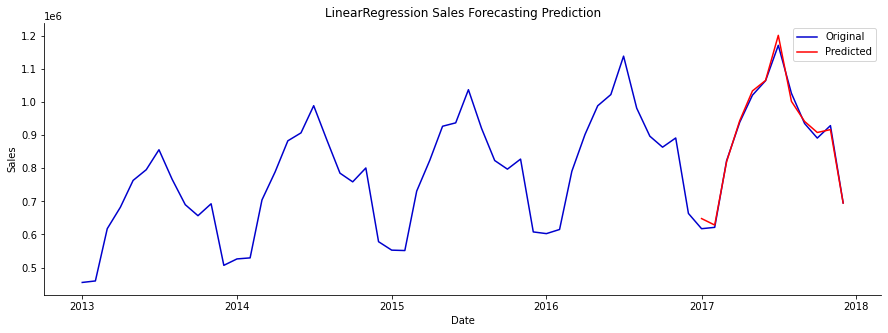

In [13]:
run_model(train, test, LinearRegression(), 'LinearRegression')

RMSE: 18661.576681781204
MAE: 15659.583333333334
R2 Score: 0.9877116480866505


c:\ProgramData\Anaconda3\envs\ai\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\ai\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


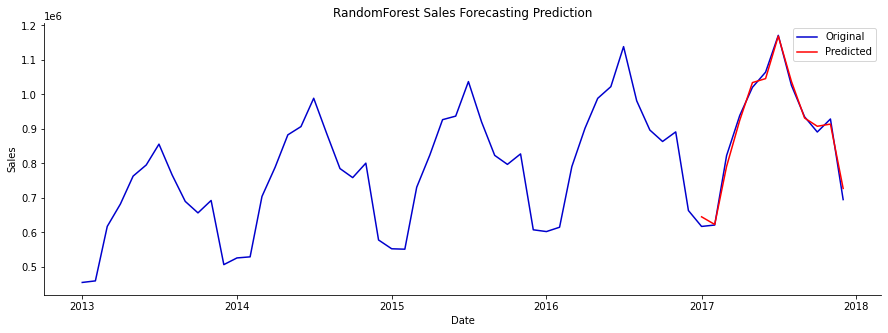

In [14]:
run_model(train, test, RandomForestRegressor(n_estimators=100, max_depth=20), 
          'RandomForest')

RMSE: 15701.003359658262
MAE: 13342.666666666666
R2 Score: 0.9913013514225064


c:\ProgramData\Anaconda3\envs\ai\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\ai\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


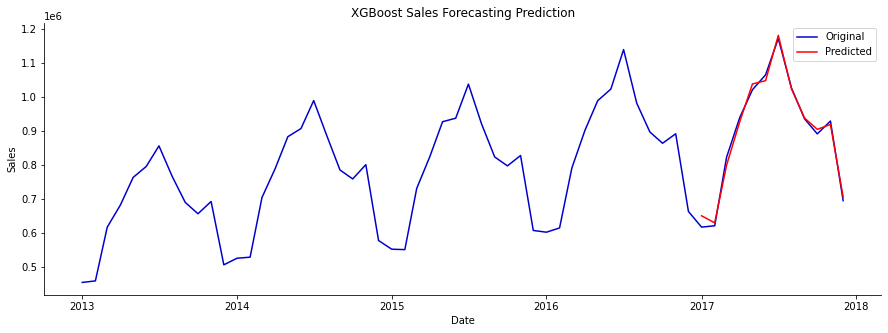

In [15]:
run_model(train, test, XGBRegressor( n_estimators=100, 
                                    learning_rate=0.2, 
                                    objective='reg:squarederror'), 'XGBoost')

In [16]:
def LSTM_model(tarin_data,test_data):
    X_train,y_train,X_test,y_test,scaler_object=scale_data(tarin_data,test_data)
    X_train = X_train.reshape(X_train.shape[0],1,X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0],1,X_test.shape[1])

    model=Sequential()
    model.add(LSTM(4, batch_input_shape=(1,X_train.shape[1],X_train.shape[2]),stateful=True))
    model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',optimizer='adam')
    model.fit(X_train,y_train,epochs=200,batch_size=1,verbose=1,shuffle=False)
    predictions=model.predict(X_test,batch_size=1)
    original_df=load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object, lstm=True)
    unscaled_df = predict_df(unscaled, original_df)
    unscaled_df.to_csv('Results_values.csv')
    get_scores(unscaled_df, original_df, 'LSTM')
    
    plot_results(unscaled_df, original_df, 'LSTM')


Epoch 1/200
35/35 [==============================] - 4s 5ms/step - loss: 0.3267
Epoch 2/200
35/35 [==============================] - 0s 4ms/step - loss: 0.2845
Epoch 3/200
35/35 [==============================] - 0s 4ms/step - loss: 0.2433
Epoch 4/200
35/35 [==============================] - 0s 4ms/step - loss: 0.2186
Epoch 5/200
35/35 [==============================] - 0s 4ms/step - loss: 0.2009
Epoch 6/200
35/35 [==============================] - 0s 5ms/step - loss: 0.1866
Epoch 7/200
35/35 [==============================] - 0s 4ms/step - loss: 0.1743
Epoch 8/200
35/35 [==============================] - 0s 4ms/step - loss: 0.1634
Epoch 9/200
35/35 [==============================] - 0s 5ms/step - loss: 0.1535
Epoch 10/200
35/35 [==============================] - 0s 6ms/step - loss: 0.1443
Epoch 11/200
35/35 [==============================] - 0s 5ms/step - loss: 0.1356
Epoch 12/200
35/35 [==============================] - 0s 5ms/step - loss: 0.1272
Epoch 13/200
35/35 [=================

c:\ProgramData\Anaconda3\envs\ai\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\ProgramData\Anaconda3\envs\ai\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


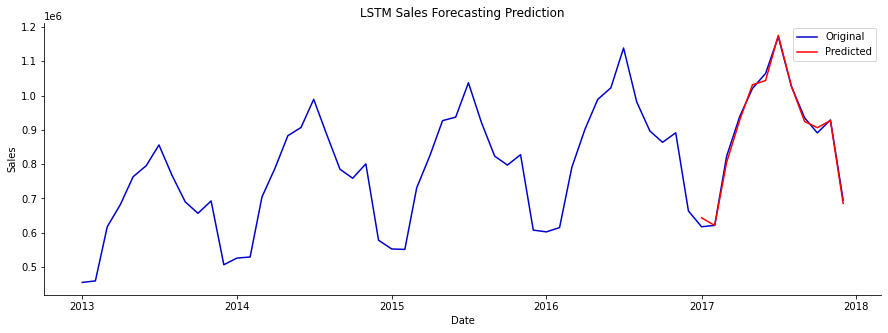

In [17]:
LSTM_model(train,test)

In [18]:
pickle.dump(model_scores, open("model_scores.p","wb"))